In [19]:

import utils
from Gian_experimental.NSGAIICustom.evolving_genome_threshold import NCSolutionWithGT
from Core.SearchSpace import SearchSpace
from Core.PRef import PRef
from Gian_experimental.NSGAIICustom.testing_in_vitro.SPRef import OptimisedSPref
import json
import numpy as np

temp_vector_path = r"C:\Users\gac8\PycharmProjects\PSSearch\retail_forecasting_data_collection\data\many_hot_vectors_250_random.csv"
temp_fitness_path = r"C:\Users\gac8\PycharmProjects\PSSearch\retail_forecasting_data_collection\data\fitness_250_random.csv"

all_vectors = np.loadtxt(temp_vector_path, delimiter=",", dtype=int)

# fitnesses_for_GA, hits_20, hits_100 = np.genfromtxt(temp_fitness_path, delimiter=",", dtype=float, usecols=(2, 4, 5))
fitnesses_for_GA, hits_100, hits_20 = np.genfromtxt(temp_fitness_path, delimiter=",", dtype=float, usecols=(2, 4, 6)).T

print("column 2, expected to be normal fitnesses ", fitnesses_for_GA)
print(f"column 4, expected to be HR 100 (high average = {np.average(hits_100):.3f})", hits_100)
print(f"column 6, expected to be HR 20 (low average = {np.average(hits_20):.3f})", hits_20)


train_test_partitions_by_seed_path = r"C:\Users\gac8\PycharmProjects\PSSearch\retail_forecasting_data_collection\data\test_indices.json"
train_test_partitions_by_seed = json.load(open(train_test_partitions_by_seed_path, "r"))

print(f"We have partitions for {len(train_test_partitions_by_seed)} seeds")


def construct_temp_spRef(which: str, seed: int) -> OptimisedSPref:
    # we make a pRef which is optimised (we represent a session as the set of the variables that are ones)
    # the fitnesses in this pRef are just the index of their row [0, 1, 2,  ...]
    
    # this allows to get any fitness we want without having to make a lot of slow code!
    
    test_indices = train_test_partitions_by_seed[str(seed)]
    if which == "test":
        row_indices = test_indices
    else:
        row_indices = list(set(range(len(all_vectors))) - set(test_indices))
        
    vectors = all_vectors[row_indices]
    trad_pRef = PRef(fitness_array=np.array(row_indices),
                           full_solution_matrix=vectors,
                           search_space=SearchSpace([2 for _ in range(250)]))
    
    sPRef = OptimisedSPref.from_pRef(trad_pRef)
    del trad_pRef
    
    return sPRef


def get_info_for_individual_ps(ps: NCSolutionWithGT, temp_test_spRef, temp_train_spRef):
    matched_test_indices, unmatched_test_indices = temp_test_spRef.partition(ps, threshold=ps.genome_threshold)
    
    matched_train_indices, unmatched_train_indices = temp_train_spRef.partition(ps, threshold=ps.genome_threshold)
    
    average_test_HR_20 = np.average(hits_20[matched_test_indices])
    average_test_HR_100 = np.average(hits_100[matched_test_indices])
    univ_test = len(matched_test_indices) / (len(matched_test_indices) + len(unmatched_test_indices))
    
    average_train_HR_20 = np.average(hits_20[matched_train_indices])
    average_train_HR_100 = np.average(hits_100[matched_train_indices])
    univ_train = len(matched_train_indices) / (len(matched_train_indices) + len(unmatched_train_indices))
    
    return univ_test, average_test_HR_20, average_test_HR_100, univ_train, average_train_HR_20, average_train_HR_100
    


column 2, expected to be normal fitnesses  [11.18746567 17.32204247  9.72239876 ...  6.85158873  8.78421211
 10.7397728 ]
column 4, expected to be HR 100 (high average = 0.547) [1. 1. 1. ... 0. 1. 1.]
column 6, expected to be HR 20 (low average = 0.245) [1. 1. 0. ... 0. 1. 1.]
We have partitions for 100 seeds


We will parse some json files in a folder, and we want to make a dataframe with the columns:
* code_name (a string)
* length (an int)
* genome_threshold (an int)
* test_coverage
* test_HR_20
* test_HR_100
* train_coverage
* train_HR_20
* train_HR_100

For every file in results_folder that ends in ".json":
* let seed = data["seed"]
* let test_sessions = construct_temp_spRef(which = "test", seed=seed)
* let train_sessions = construct_temp_spRef(which = "train", seed=seed)
* read data["data"], which contains many runs with different settings. Iterate over each run
    * each run has a code_name, read it in run["config"]["code_name"]
    * each run has a set of produced outputs, under run["results"]
        * for each output, let ps = NCSolutionWithGT(values = set(output["pattern"], genome_threshold = output["threshold"]
        * then let length = len(ps)
        * genome_threshold = ps.genome_threshold
        * test_coverage, ..., train_HR_100  = get_info_for_individual_ps(ps, test_sessions, train_sessions)
        * put the relevant information as a row in the dataframe mentioned in the beginning


In [22]:
from tqdm import tqdm
import os
import json
import pandas as pd


def process_results_folder(results_folder):
    rows = []

    for filename in os.listdir(results_folder):
        print("processing file ", filename)
        if not filename.endswith(".json"):
            continue

        filepath = os.path.join(results_folder, filename)
        with open(filepath, 'r') as f:
            data = json.load(f)

        seed = data["extra_info"]["seed"]
        test_sessions = construct_temp_spRef(which="test", seed=seed)
        train_sessions = construct_temp_spRef(which="train", seed=seed)

        for run in data["data"]:
            code_name = run["config"]["code_name"]
            for output in tqdm(run["results"]):
                ps = NCSolutionWithGT(
                    values=set(output["pattern"]),
                    genome_threshold=output["threshold"]
                )
                length = len(ps)
                genome_threshold = ps.genome_threshold

                (
                    test_coverage,
                    test_HR_20,
                    test_HR_100,
                    train_coverage,
                    train_HR_20,
                    train_HR_100
                ) = get_info_for_individual_ps(ps, test_sessions, train_sessions)

                row = {
                    "code_name": code_name,
                    "length": length,
                    "genome_threshold": genome_threshold,
                    "test_coverage": test_coverage,
                    "test_HR_20": test_HR_20,
                    "test_HR_100": test_HR_100,
                    "train_coverage": train_coverage,
                    "train_HR_20": train_HR_20,
                    "train_HR_100": train_HR_100,
                }

                rows.append(row)

    return pd.DataFrame(rows)

# Usage
# df = process_results_folder("path/to/results_folder")
# print(df.head())


In [23]:
results_folder = r"C:\Users\gac8\PycharmProjects\PSSearch\retail_forecasting_data_collection\local_results"
results_df = process_results_folder(results_folder)

display(results_df)

processing file  result_06-22-H13'm'58's07.json.txt
processing file  result_06-22-H15'm'08's06.json


100%|██████████| 94/94 [00:04<00:00, 19.15it/s]


processing file  result_06-22-H16'm'14's24.json


100%|██████████| 91/91 [00:04<00:00, 19.20it/s]


processing file  result_06-22-H17'm'20's02.json


100%|██████████| 82/82 [00:04<00:00, 17.93it/s]


processing file  result_06-22-H18'm'27's37.json


100%|██████████| 54/54 [00:02<00:00, 24.50it/s]


processing file  result_06-22-H19'm'34's42.json


100%|██████████| 79/79 [00:05<00:00, 15.05it/s]


processing file  result_06-22-H20'm'42's11.json


100%|██████████| 28/28 [00:01<00:00, 27.21it/s]


processing file  result_06-22-H21'm'51's51.json


100%|██████████| 44/44 [00:01<00:00, 35.57it/s]


processing file  result_06-22-H23'm'02's28.json


100%|██████████| 43/43 [00:02<00:00, 15.23it/s]


processing file  result_06-23-H00'm'09's37.json


100%|██████████| 81/81 [00:02<00:00, 28.63it/s]


processing file  result_06-23-H01'm'15's05.json


100%|██████████| 77/77 [00:04<00:00, 16.13it/s]


processing file  result_06-23-H02'm'23's13.json


100%|██████████| 73/73 [00:03<00:00, 20.88it/s]


processing file  result_06-23-H03'm'33's49.json


100%|██████████| 91/91 [00:04<00:00, 18.76it/s]


processing file  result_06-23-H04'm'39's53.json


100%|██████████| 64/64 [00:03<00:00, 17.04it/s]


processing file  result_06-23-H05'm'48's38.json


100%|██████████| 51/51 [00:02<00:00, 23.29it/s]


processing file  result_06-23-H06'm'55's06.json


100%|██████████| 83/83 [00:04<00:00, 20.59it/s]


processing file  result_06-23-H08'm'01's08.json


100%|██████████| 55/55 [00:01<00:00, 28.72it/s]


processing file  result_06-23-H09'm'09's37.json


100%|██████████| 59/59 [00:02<00:00, 26.43it/s]


processing file  result_06-23-H10'm'28's26.json


100%|██████████| 80/80 [00:04<00:00, 18.11it/s]


,code_name,length,genome_threshold,test_coverage,test_HR_20,test_HR_100,train_coverage,train_HR_20,train_HR_100
0,[CS CM CC][Len SSize MFit CAtom][G3],14,3,0.091574,0.300830,0.618257,0.090236,0.306579,0.631053
1,[CS CM CC][Len SSize MFit CAtom][G3],17,3,0.185048,0.265914,0.610370,0.182869,0.284638,0.615375
2,[CS CM CC][Len SSize MFit CAtom][G3],12,3,0.095564,0.249503,0.592445,0.093679,0.251204,0.579214
3,[CS CM CC][Len SSize MFit CAtom][G3],22,3,0.206897,0.258035,0.587236,0.211864,0.272360,0.592020
4,[CS CM CC][Len SSize MFit CAtom][G3],7,3,0.023463,0.352227,0.655870,0.024862,0.299904,0.642789
...,...,...,...,...,...,...,...,...,...
13365,[CS CM CC][Len SSize MFit CAtom][G5],53,5,0.218961,0.272885,0.592191,0.221528,0.276343,0.588916
13366,[CS CM CC][Len SSize MFit CAtom][G5],12,5,0.037998,0.302500,0.687500,0.042339,0.325294,0.634885
13367,[CS CM CC][Len SSize MFit CAtom][G5],43,5,0.221906,0.274401,0.590753,0.224473,0.280334,0.598963
13368,[CS CM CC][Len SSize MFit CAtom][G5],14,5,0.023558,0.326613,0.705645,0.024625,0.333655,0.644166


In [25]:
import utils

scratch_path = r"C:\Users\gac8\PycharmProjects\PSSearch\retail_forecasting_data_collection\scratch_processing\processed"+utils.get_formatted_timestamp()+".csv"


results_df.to_csv(scratch_path)

Code name: [CS CM CC][Len MFit CAtom][G3]


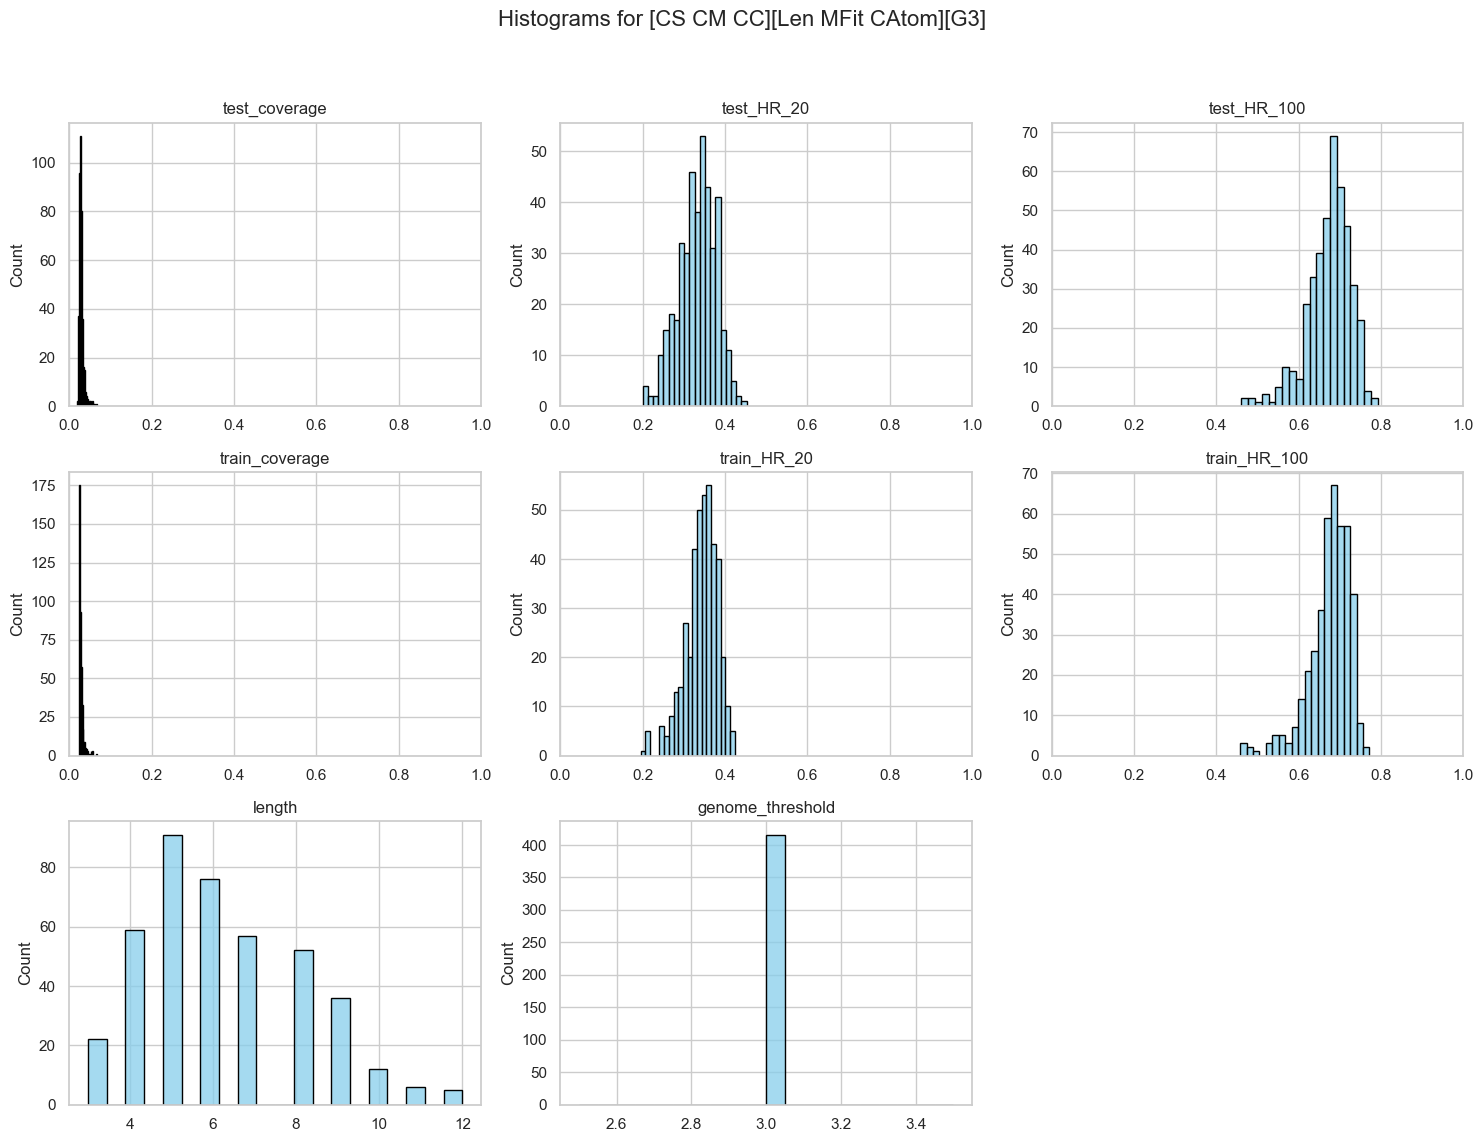

Code name: [CS CM CC][Len SSize CAtom][G3]


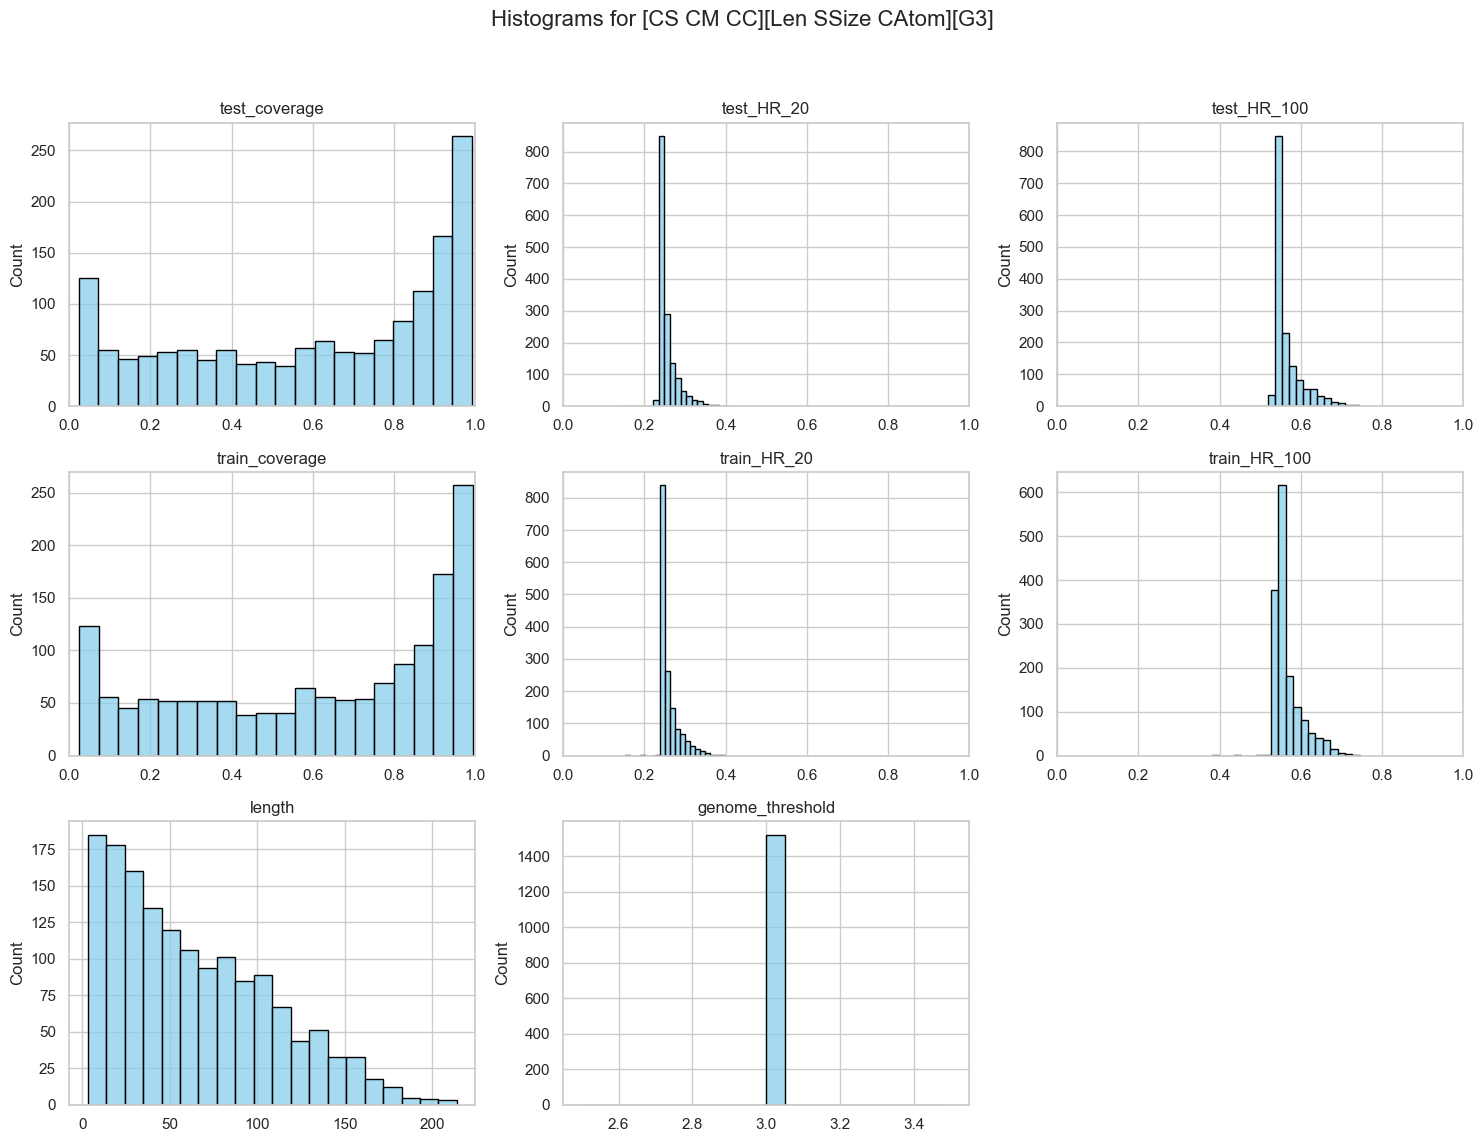

Code name: [CS CM CC][Len SSize MFit CAtom][G3]


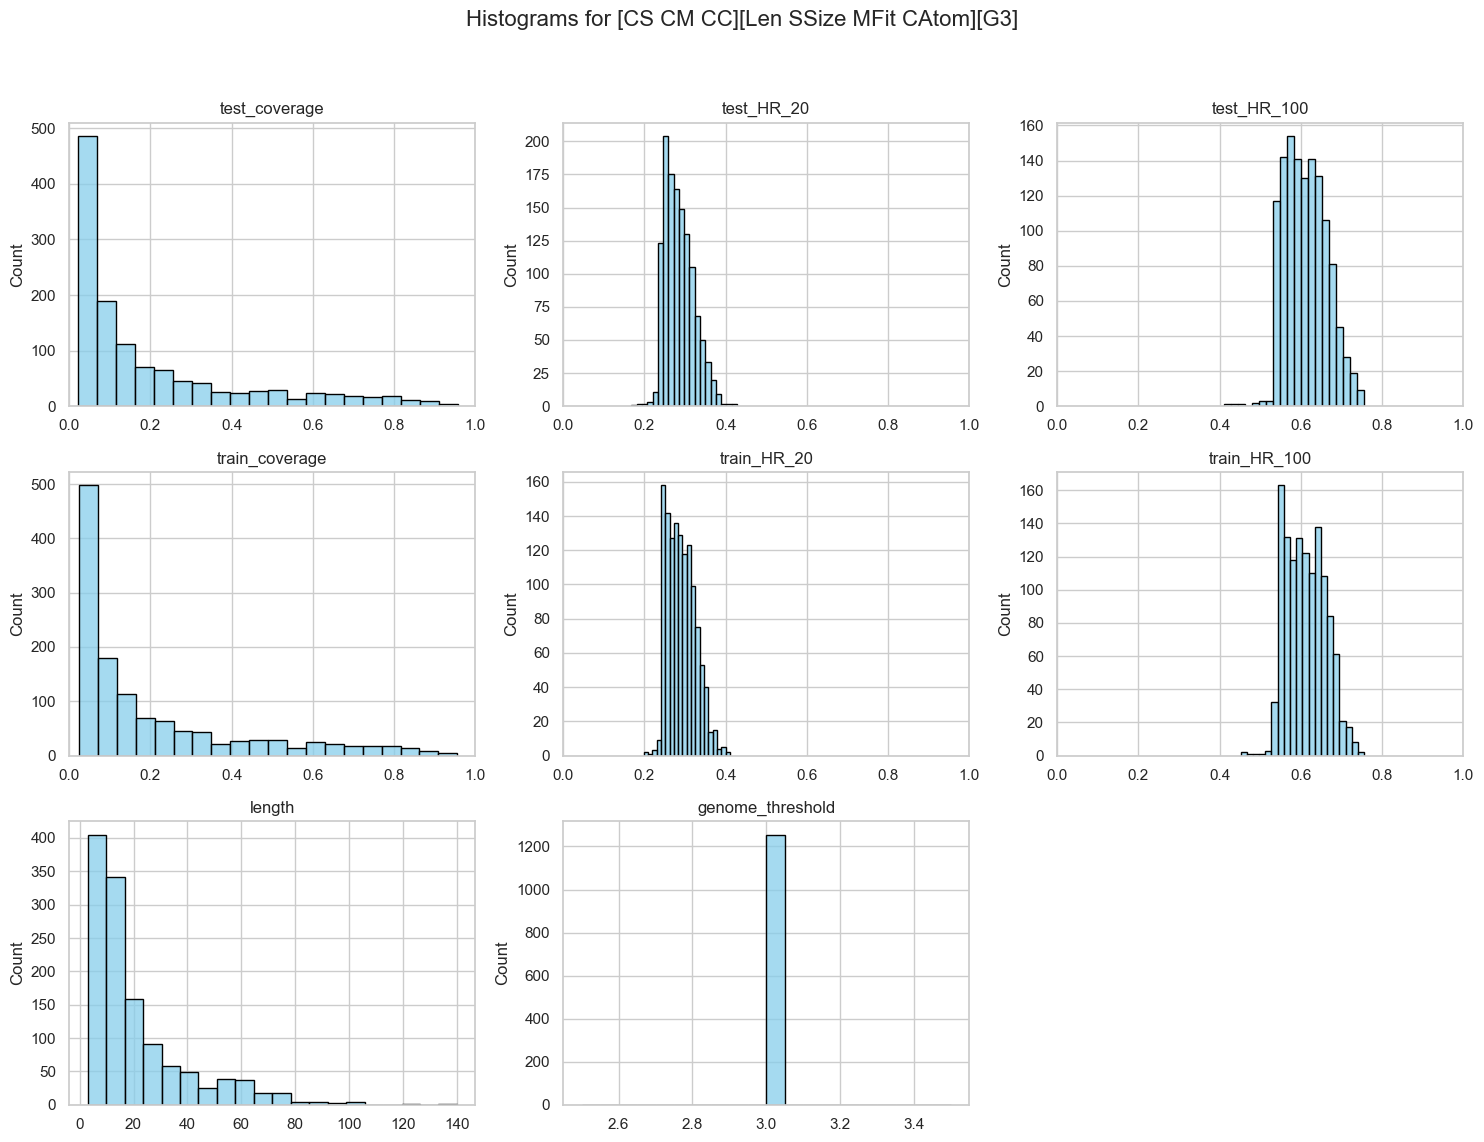

Code name: [CS CM CC][Len SSize MFit CAtom][G4]


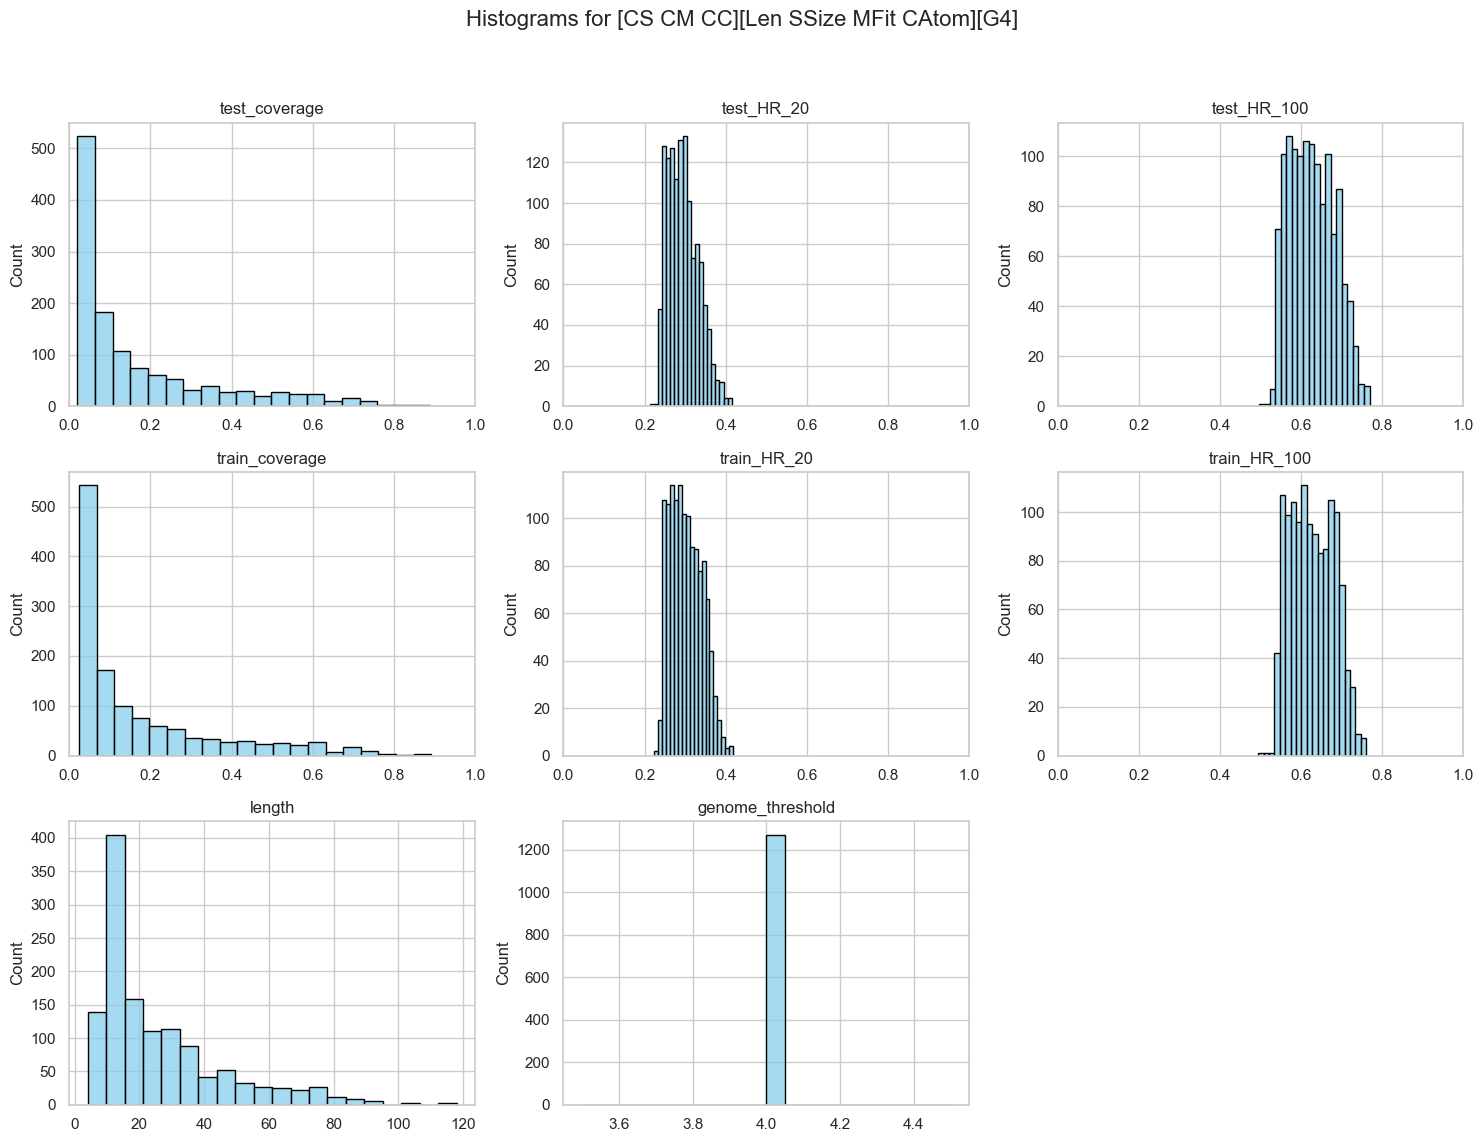

Code name: [CS CM CC][Len SSize MFit CAtom][G5]


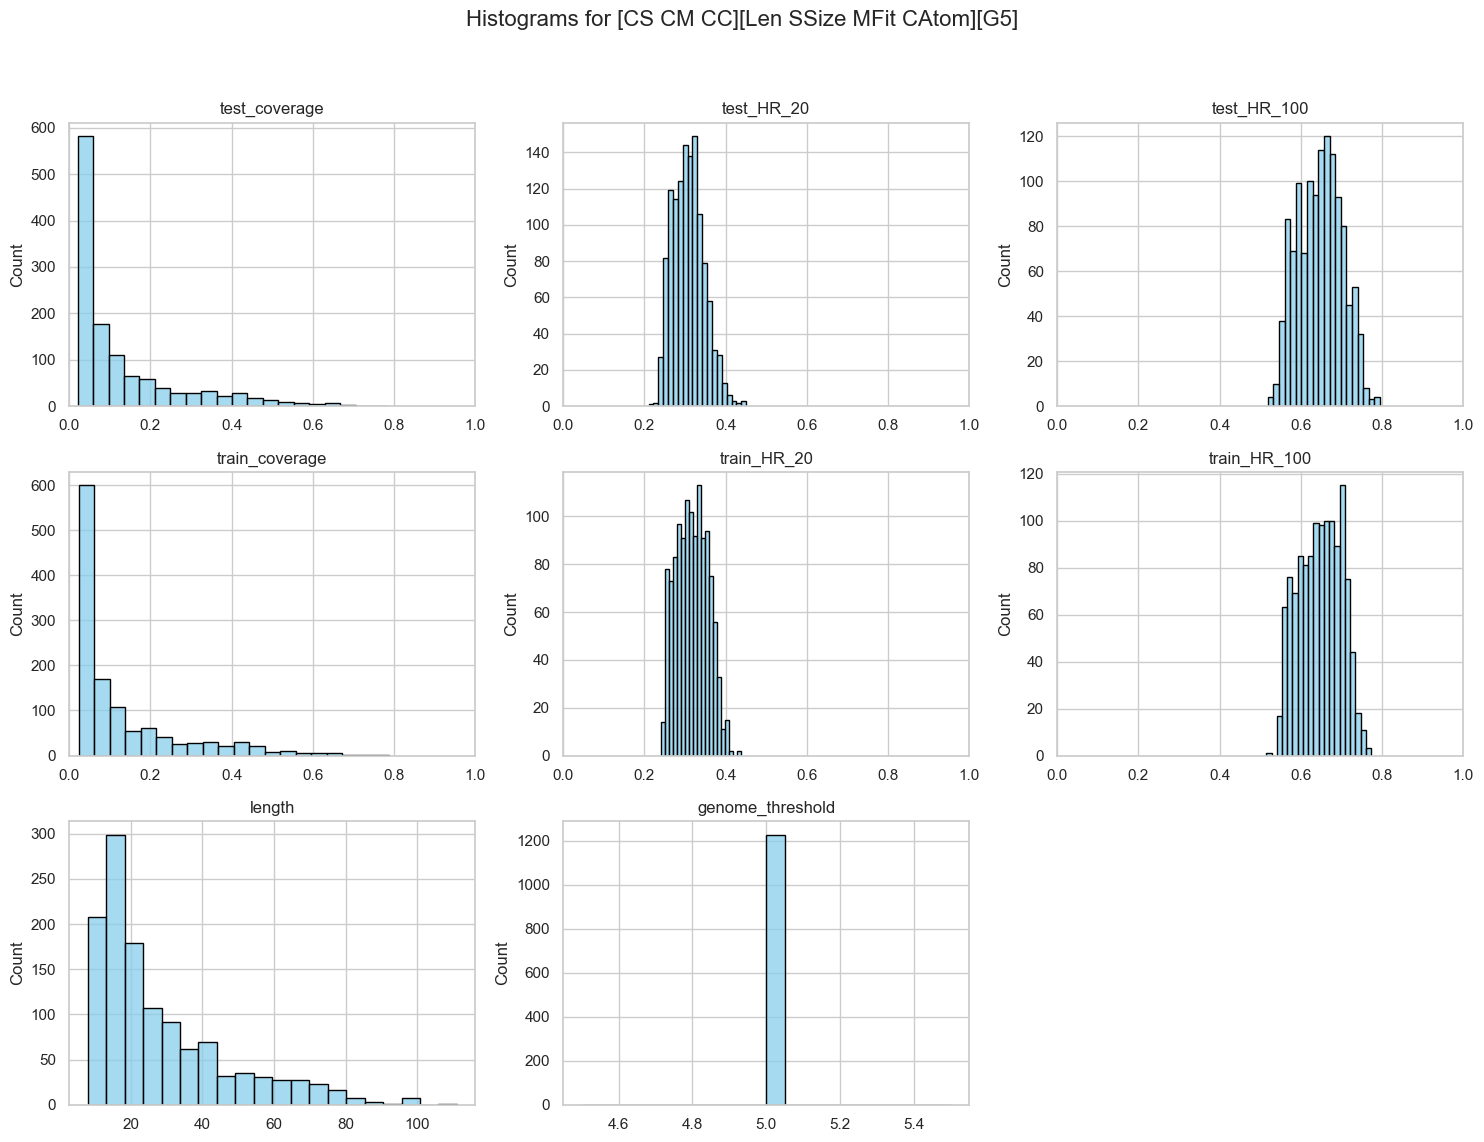

Code name: [CS CM CC][Len SSize MFit CAtom][Gauto]


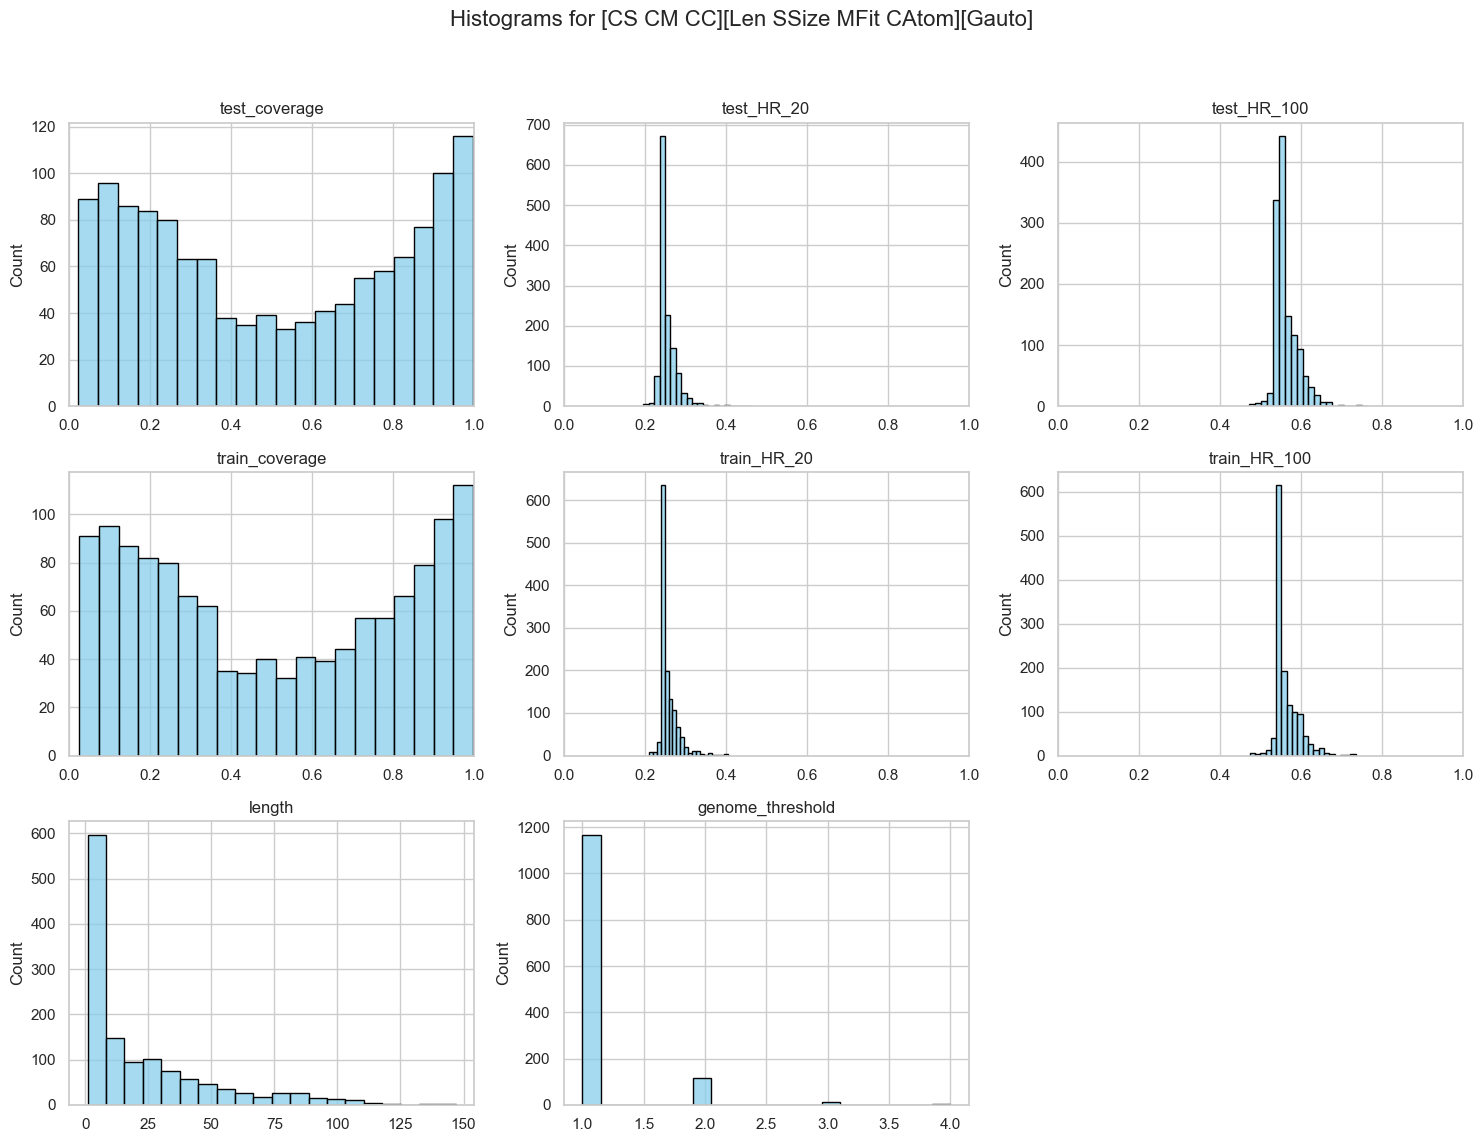

Code name: [CS CM CC][Len SSize MFit][G3]


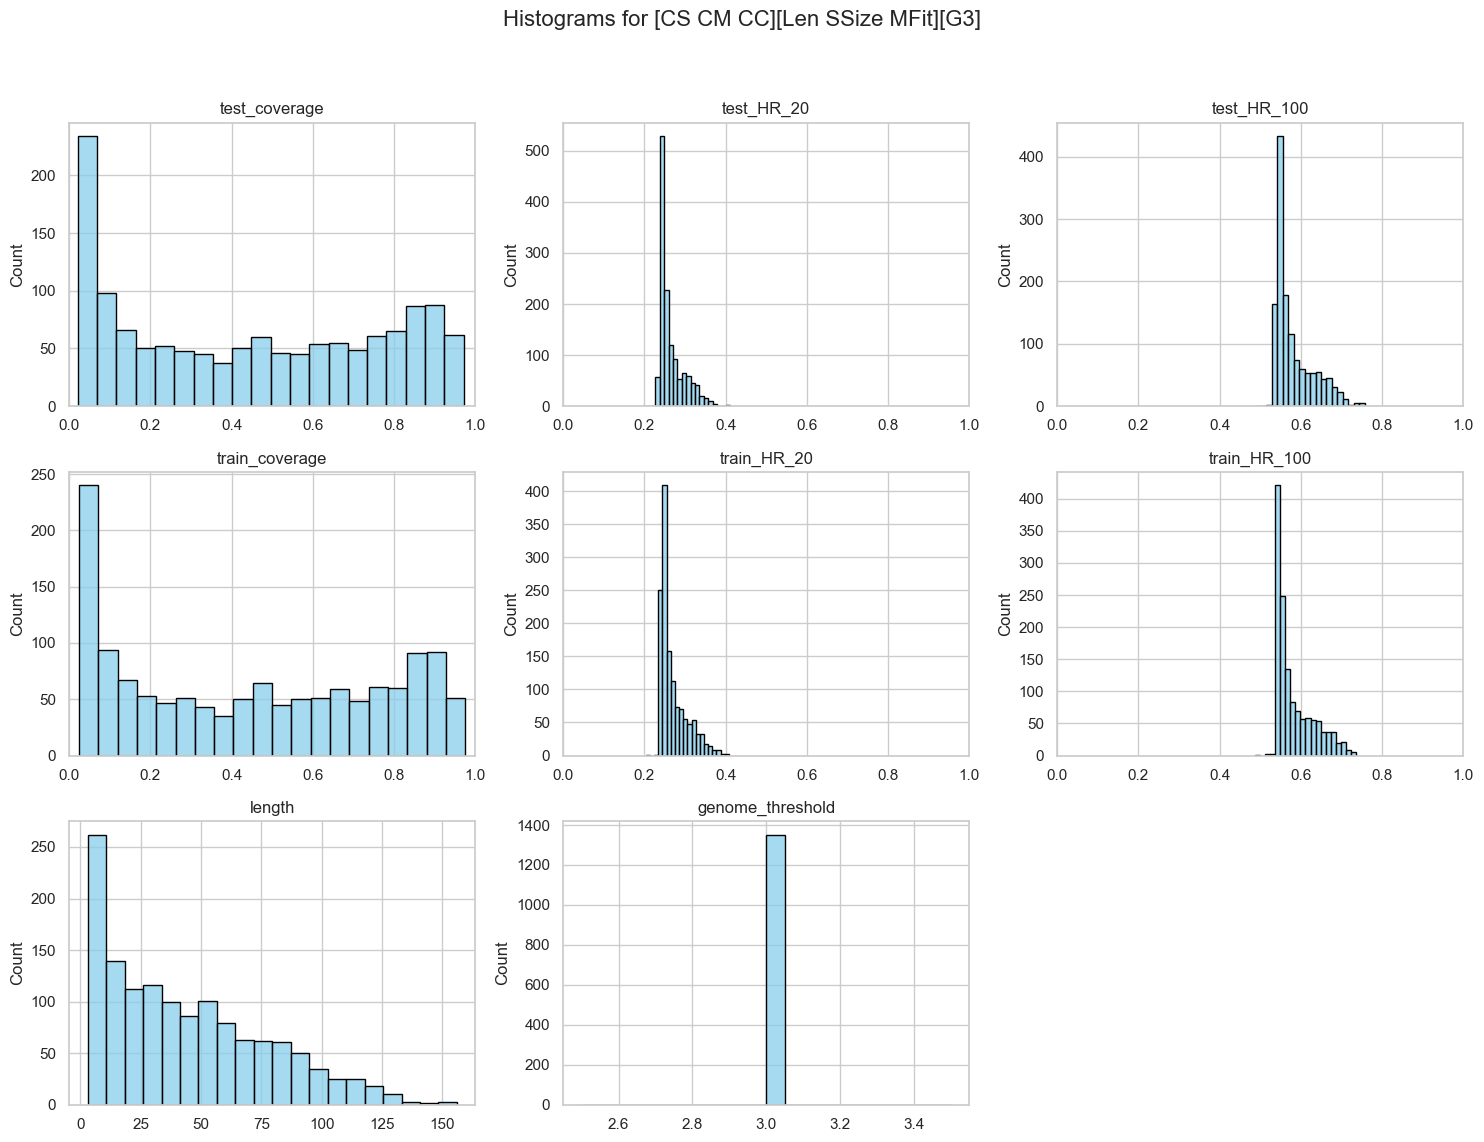

Code name: [CS CM CC][SSize MFit CAtom][G3]


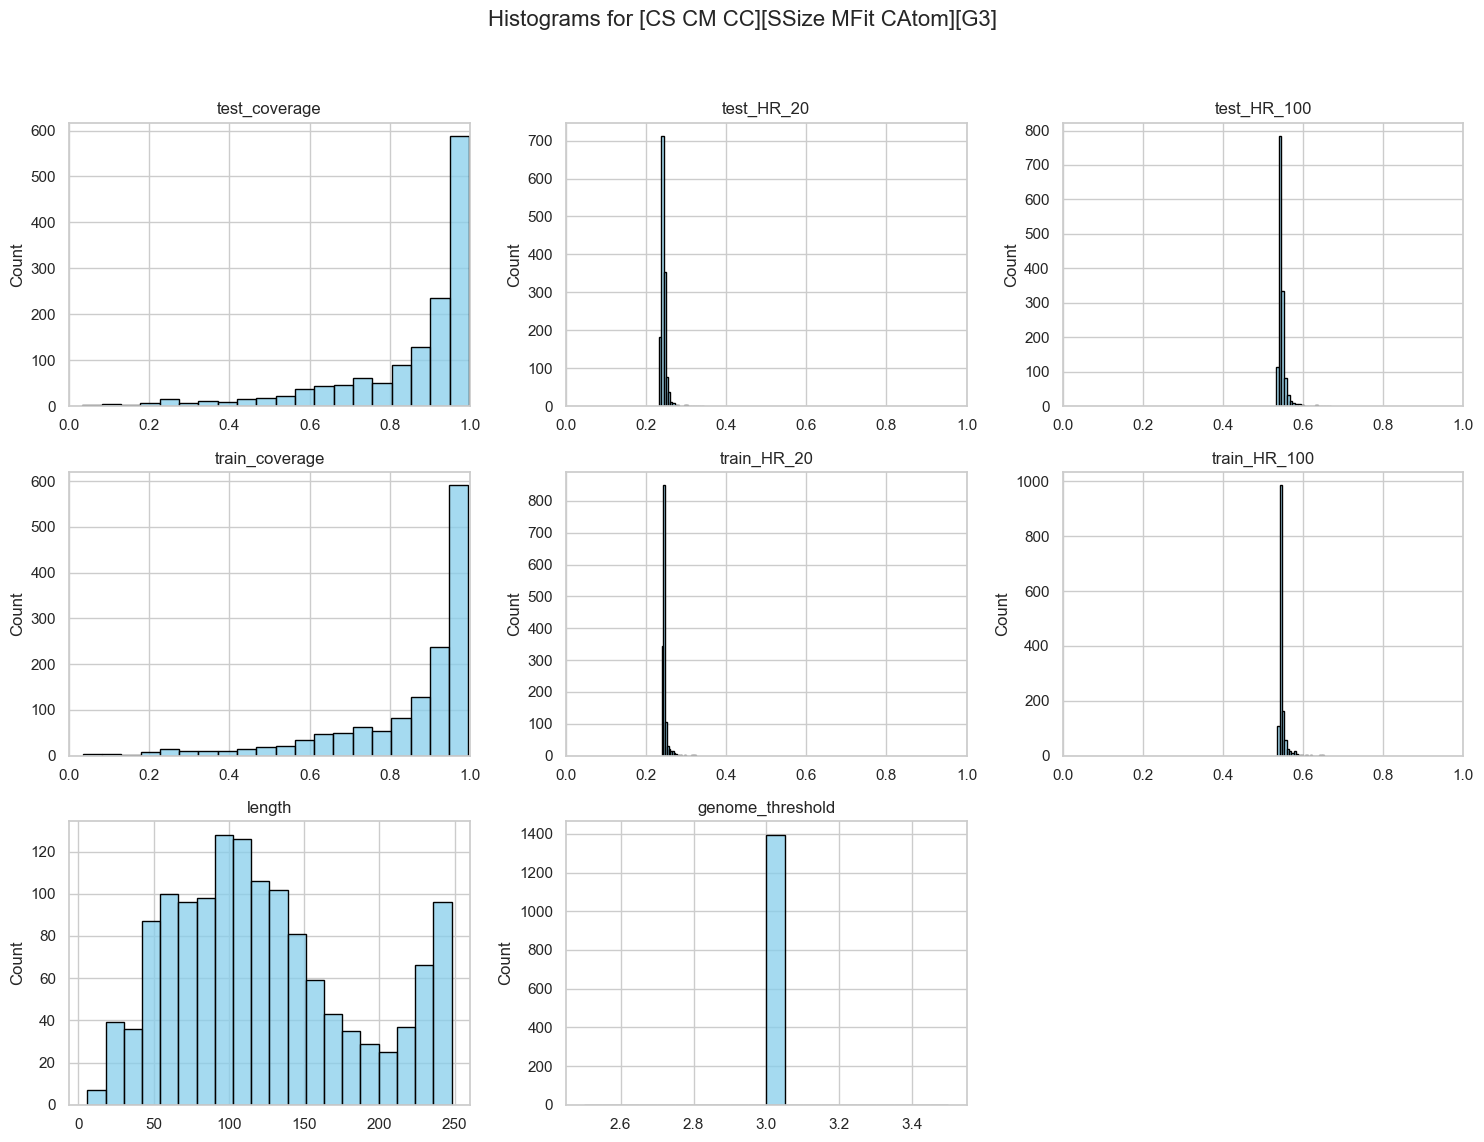

Code name: [CS CM OC][Len SSize MFit CAtom][G3]


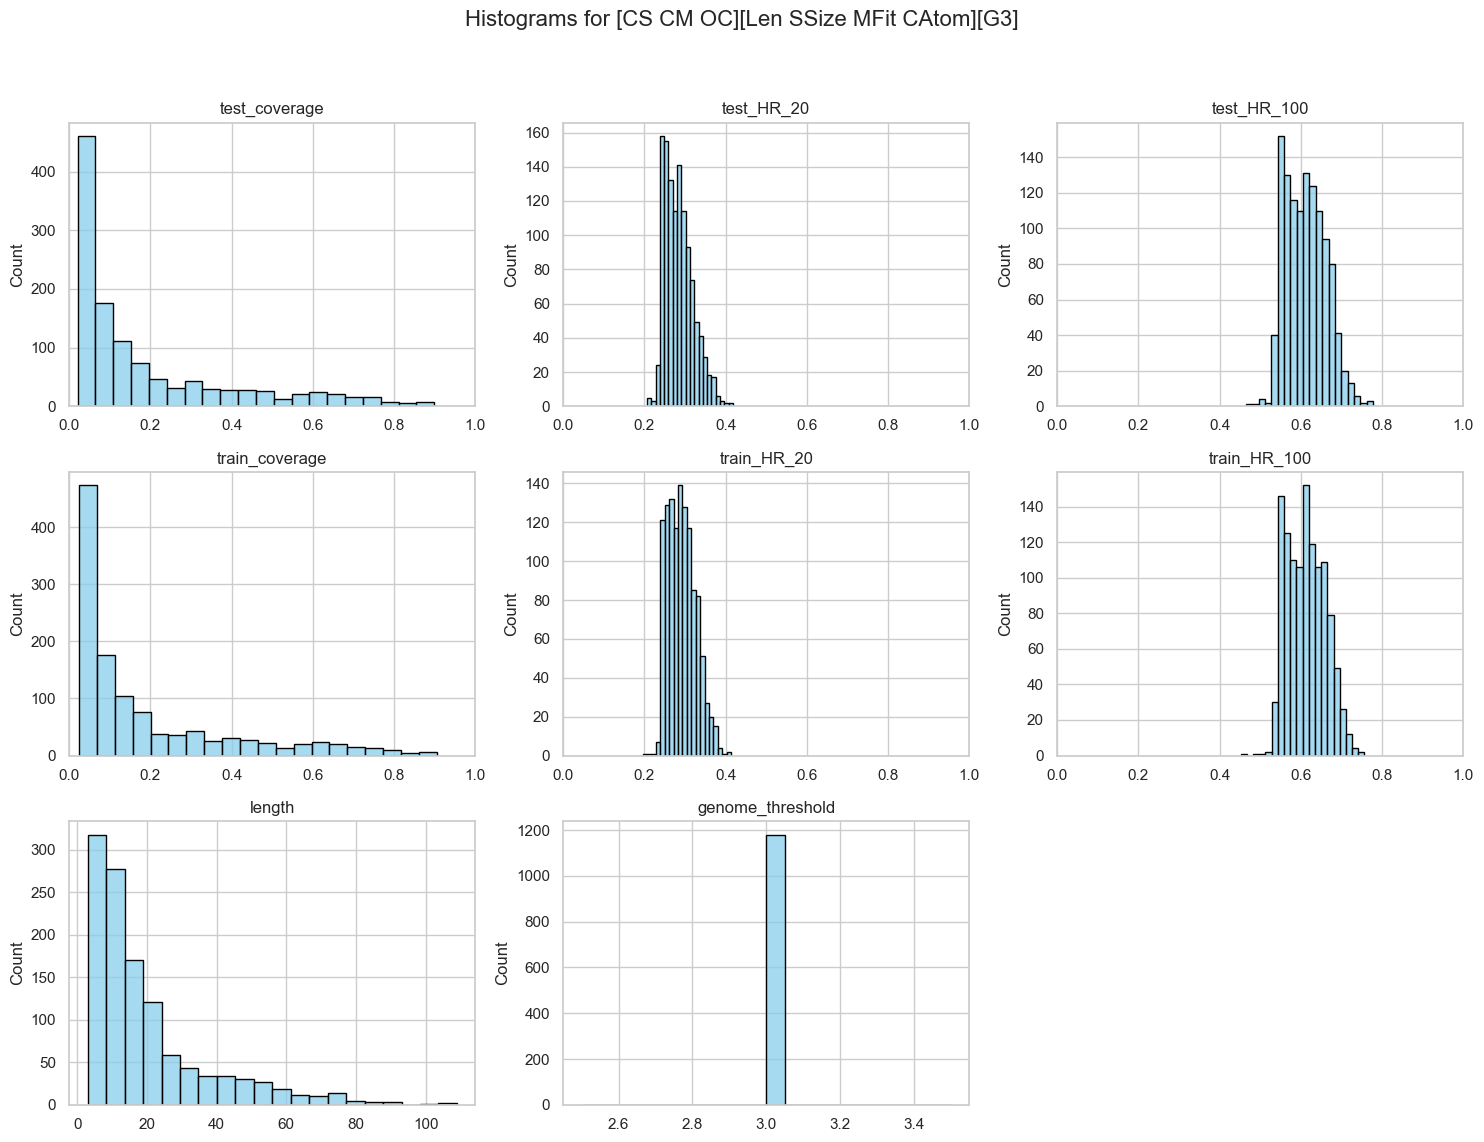

Code name: [CS OM CC][Len SSize MFit CAtom][G3]


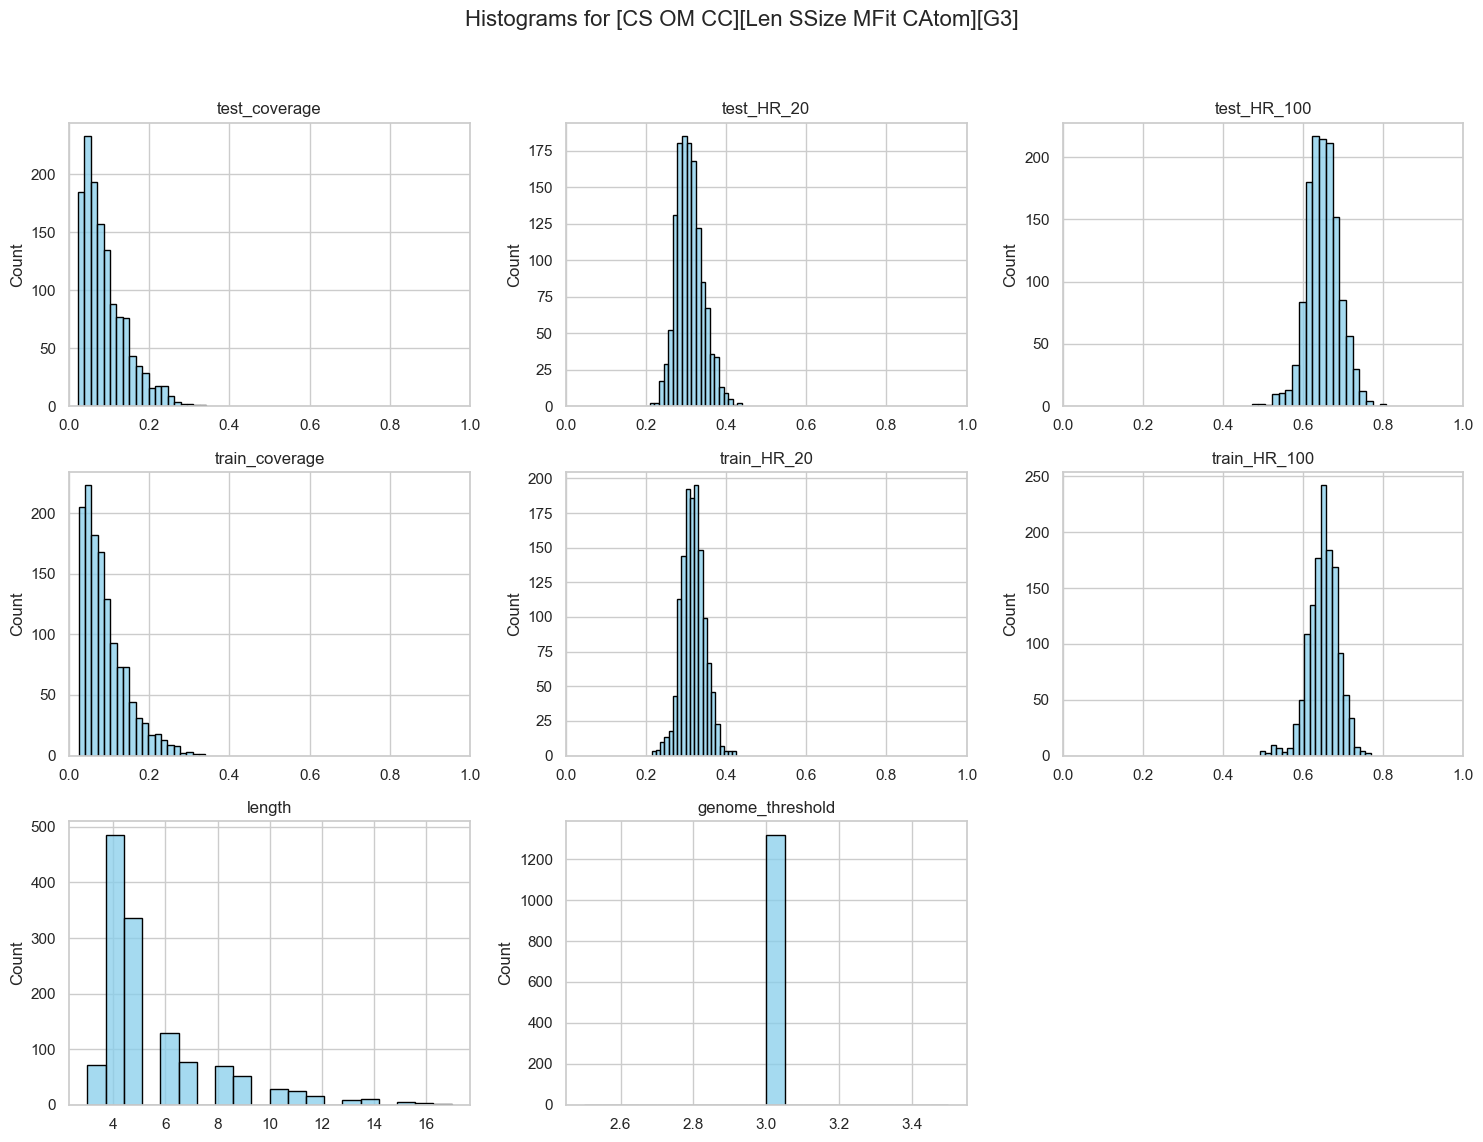

Code name: [OS CM CC][Len SSize MFit CAtom][G3]


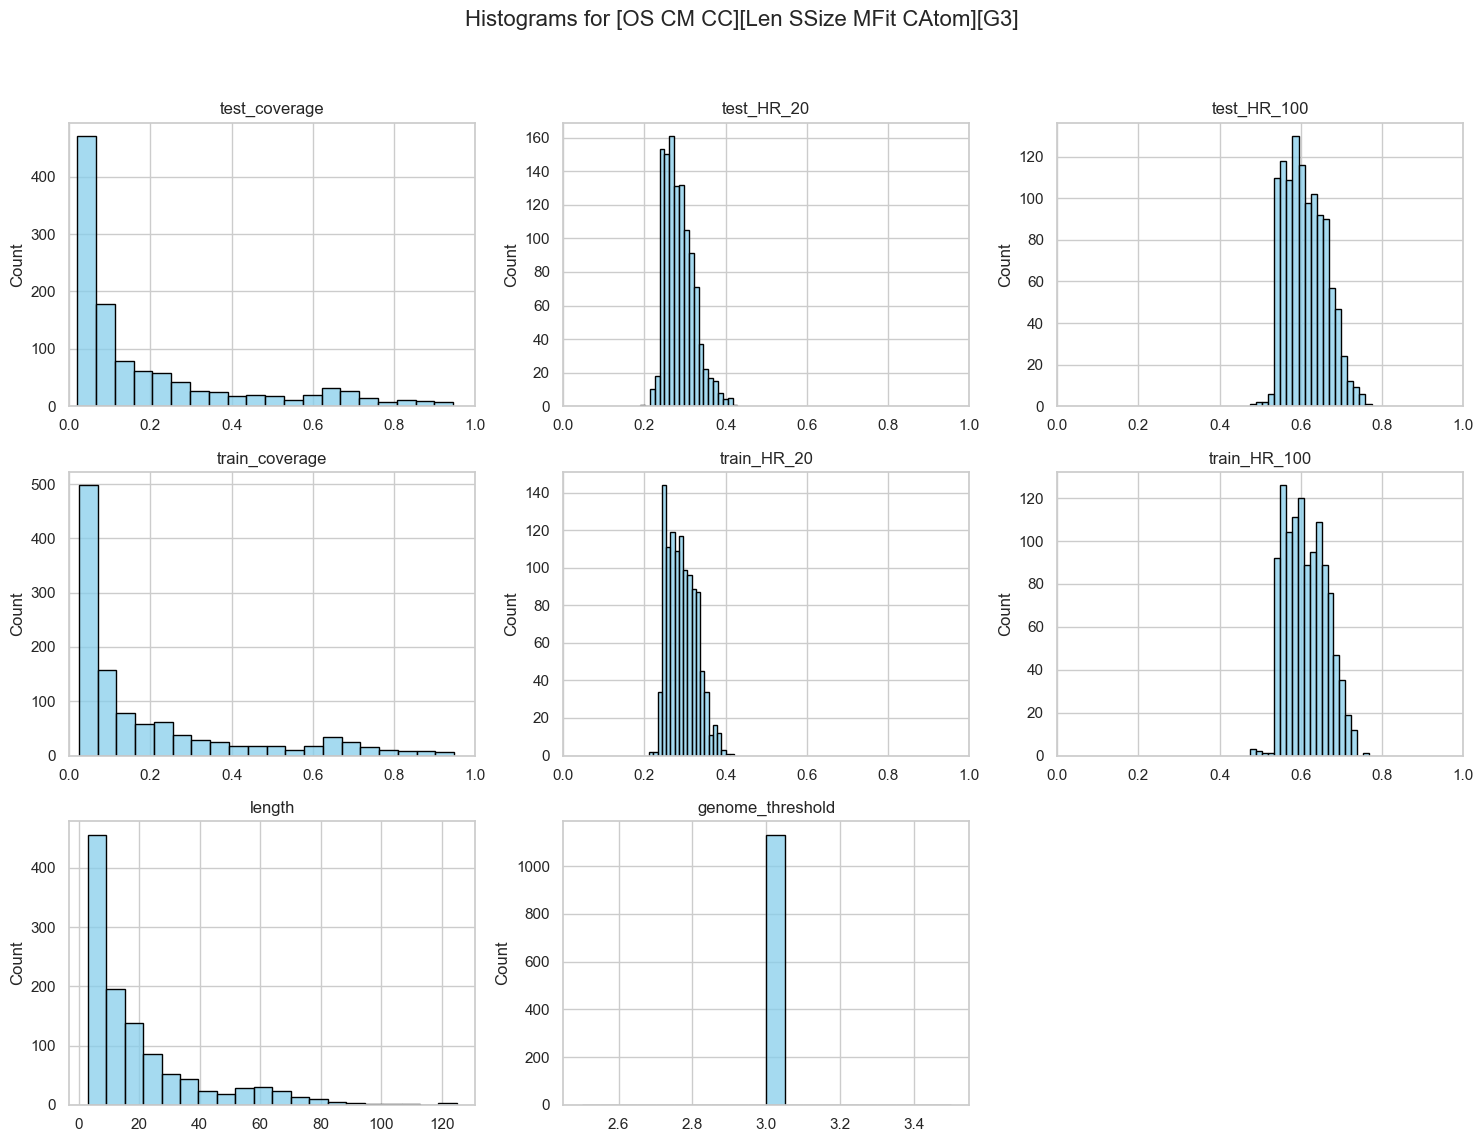

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (6, 4)

# Define metrics in the order you want them shown
metrics = [
    "test_coverage",
    "test_HR_20",
    "test_HR_100",
    "train_coverage",
    "train_HR_20",
    "train_HR_100",
    "length",
    "genome_threshold",
]

# Define which metrics are [0, 1] bounded
bounded_metrics = {
    "test_coverage", "test_HR_20", "test_HR_100",
    "train_coverage", "train_HR_20", "train_HR_100"
}

# Loop through each code_name
for code_name, group_df in results_df.groupby("code_name"):
    print(f"Code name: {code_name}")

    n_metrics = len(metrics)
    n_cols = 3
    # We want test_coverage to start on a new row, so we insert a row break before it
    row_break_index = metrics.index("test_coverage")
    top_half = metrics[:row_break_index]
    bottom_half = metrics[row_break_index:]

    # Total rows = ceil(len(top_half) / n_cols) + ceil(len(bottom_half) / n_cols)
    n_top_rows = -(-len(top_half) // n_cols)
    n_bottom_rows = -(-len(bottom_half) // n_cols)
    total_rows = n_top_rows + n_bottom_rows

    fig, axs = plt.subplots(total_rows, n_cols, figsize=(n_cols * 5, total_rows * 4))
    axs = axs.flatten()

    for i, metric in enumerate(metrics):
        ax = axs[i]
        sns.histplot(group_df[metric], bins=20, kde=False, ax=ax, color="skyblue", edgecolor="black")
        ax.set_title(metric)
        if metric in bounded_metrics:
            ax.set_xlim(0, 1)
        ax.set_xlabel("")
        ax.set_ylabel("Count")

    # Hide any unused subplots
    for j in range(len(metrics), len(axs)):
        axs[j].axis("off")

    plt.suptitle(f"Histograms for {code_name}", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


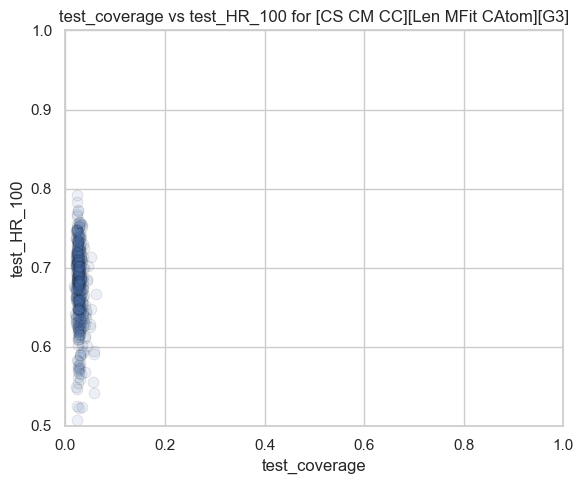

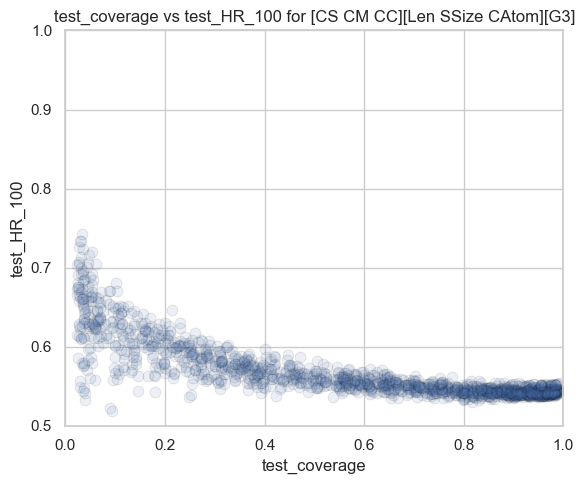

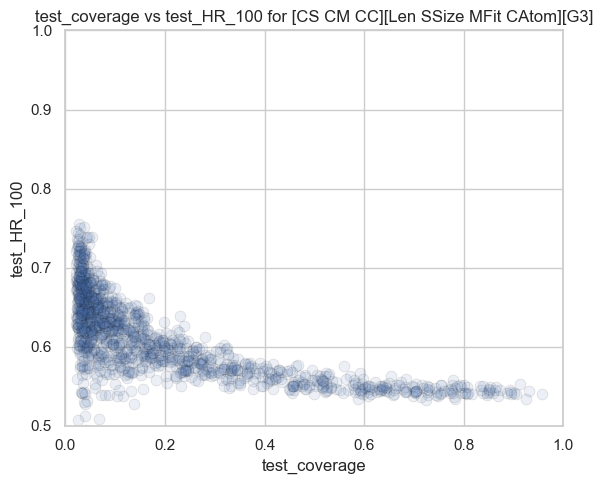

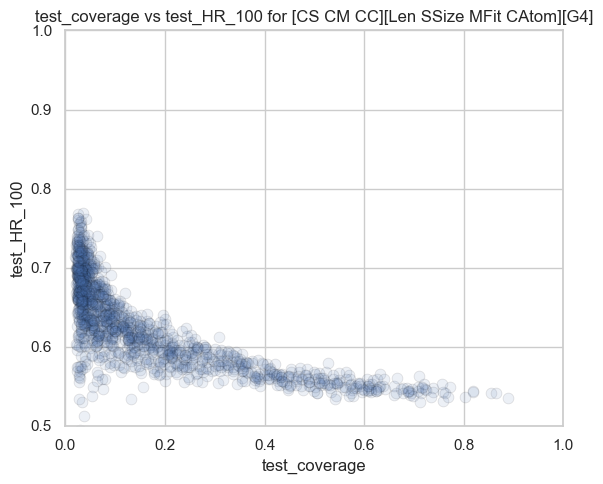

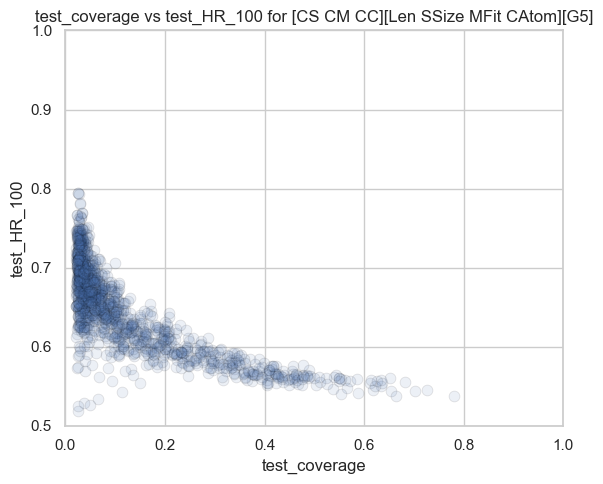

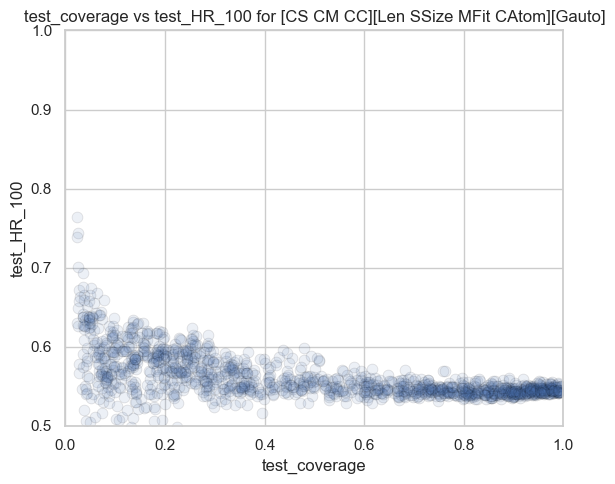

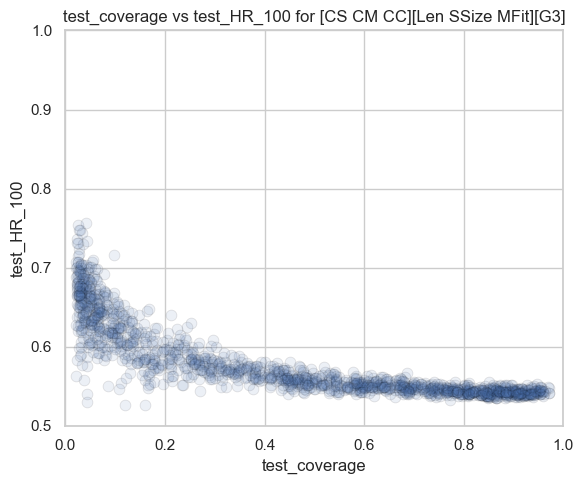

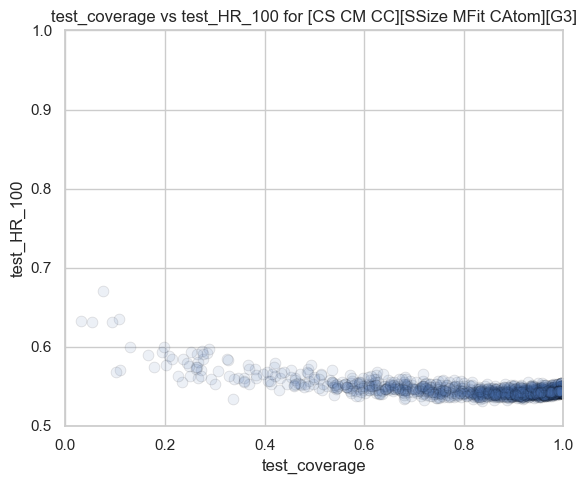

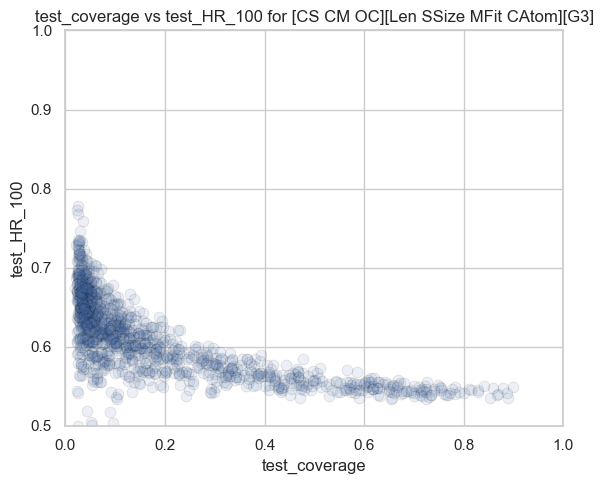

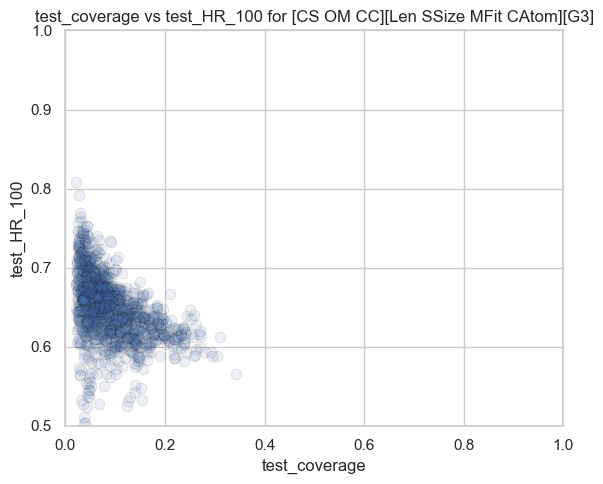

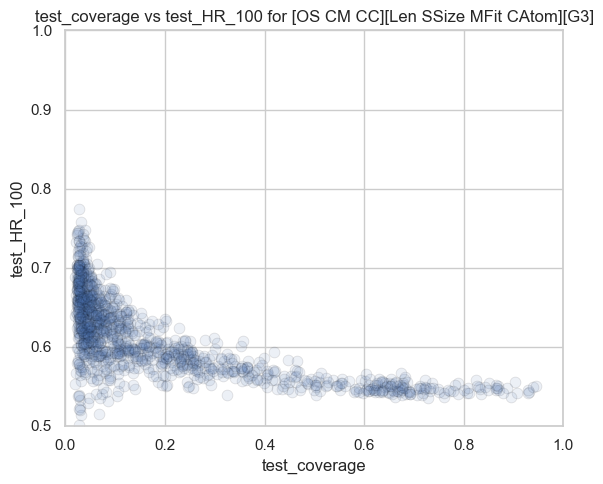

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for consistency
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (6, 5)

for code_name, group_df in results_df.groupby("code_name"):
    plt.figure(figsize=(6, 5))
    sns.scatterplot(
        data=group_df,
        x="test_coverage",
        y="test_HR_100",
        s=60,
        alpha=0.1,
        edgecolor="black"
    )

    plt.title(f"test_coverage vs test_HR_100 for {code_name}")
    plt.xlabel("test_coverage")
    plt.ylabel("test_HR_100")
    plt.xlim(0, 1)
    plt.ylim(0.5, 1)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
